# Pruebas

In [1]:
import networkx as nx
import copy
import numpy as np
import xgi
from itertools import permutations
from itertools import combinations
from collections import Counter

from hyperfunctions import HEC_ours

## Increasing the edge to the desired length

In [2]:
edgeset = set()
edgeset.add((1,2,3))
for edge in edgeset:
    print(edge)

(1, 2, 3)


In [3]:
def increase_edge(edgeset):
    '''
    Given some edges, returns all edges whose length is one higher with those same nodes
    :param edgeset :: set of edges:
    :return new_edgeset :: modified set of edges:
    '''
    
    new_edgeset = set()
    counterlist = [] # all counters must be different, otherwise we don't add the node
    for edge in edgeset:
        
        edge = list(edge)
        
        # Add each node in the edge to itself, increasing in 1 the length
        for node in edge:
            
            copyedge = copy.copy(edge)
            copyedge.append(node)
            
            # Check for duplicates (permuted edges already with the same node count within)
            if Counter(copyedge) not in counterlist: 
                new_edgeset.add(tuple(copyedge))
                
                counterlist.append(Counter(copyedge))
            
    return new_edgeset


In [4]:
increase_edge(edgeset)

{(1, 2, 3, 1), (1, 2, 3, 2), (1, 2, 3, 3)}

### Do this repeatedly up to the desired length

In [5]:
while len(list(edgeset)[0]) < 5:
    edgeset = increase_edge(edgeset)
    
print(edgeset)

{(1, 2, 3, 1, 3), (1, 2, 3, 2, 3), (1, 2, 3, 3, 3), (1, 2, 3, 1, 2), (1, 2, 3, 2, 2), (1, 2, 3, 1, 1)}


In [6]:
for edge in edgeset:
    print(edge, "->", set(permutations(edge)))

(1, 2, 3, 1, 3) -> {(2, 3, 1, 1, 3), (2, 1, 1, 3, 3), (3, 1, 3, 2, 1), (3, 1, 1, 3, 2), (1, 3, 3, 1, 2), (1, 1, 2, 3, 3), (1, 1, 3, 2, 3), (1, 1, 3, 3, 2), (3, 1, 3, 1, 2), (1, 2, 3, 3, 1), (3, 1, 1, 2, 3), (2, 1, 3, 3, 1), (1, 2, 1, 3, 3), (1, 3, 1, 3, 2), (3, 3, 1, 2, 1), (3, 1, 2, 3, 1), (1, 2, 3, 1, 3), (1, 3, 2, 3, 1), (3, 3, 1, 1, 2), (1, 3, 1, 2, 3), (2, 1, 3, 1, 3), (1, 3, 2, 1, 3), (3, 3, 2, 1, 1), (3, 2, 1, 3, 1), (2, 3, 3, 1, 1), (3, 1, 2, 1, 3), (2, 3, 1, 3, 1), (3, 2, 1, 1, 3), (1, 3, 3, 2, 1), (3, 2, 3, 1, 1)}
(1, 2, 3, 2, 3) -> {(2, 1, 3, 3, 2), (1, 2, 3, 2, 3), (2, 1, 2, 3, 3), (3, 3, 2, 2, 1), (3, 1, 2, 3, 2), (3, 3, 1, 2, 2), (2, 3, 2, 3, 1), (1, 3, 2, 2, 3), (2, 2, 3, 3, 1), (1, 3, 2, 3, 2), (2, 1, 3, 2, 3), (2, 2, 3, 1, 3), (3, 2, 2, 3, 1), (3, 3, 2, 1, 2), (2, 3, 3, 1, 2), (2, 3, 3, 2, 1), (3, 1, 2, 2, 3), (3, 2, 1, 2, 3), (3, 2, 1, 3, 2), (3, 2, 3, 2, 1), (2, 3, 1, 3, 2), (1, 2, 2, 3, 3), (2, 3, 2, 1, 3), (3, 2, 2, 1, 3), (2, 3, 1, 2, 3), (1, 3, 3, 2, 2), (3, 2, 3

In [7]:
for edge in edgeset:
    print(edge, "->", Counter(edge), "->", np.prod([np.math.factorial(alpha) for alpha in Counter(edge).values()]))

(1, 2, 3, 1, 3) -> Counter({1: 2, 3: 2, 2: 1}) -> 4
(1, 2, 3, 2, 3) -> Counter({2: 2, 3: 2, 1: 1}) -> 4
(1, 2, 3, 3, 3) -> Counter({3: 3, 1: 1, 2: 1}) -> 6
(1, 2, 3, 1, 2) -> Counter({1: 2, 2: 2, 3: 1}) -> 4
(1, 2, 3, 2, 2) -> Counter({2: 3, 1: 1, 3: 1}) -> 6
(1, 2, 3, 1, 1) -> Counter({1: 3, 2: 1, 3: 1}) -> 6


In [8]:
edgeset

{(1, 2, 3, 1, 1),
 (1, 2, 3, 1, 2),
 (1, 2, 3, 1, 3),
 (1, 2, 3, 2, 2),
 (1, 2, 3, 2, 3),
 (1, 2, 3, 3, 3)}

### Calculate the alpha factor for the collection of edges

In [9]:
psprod = lambda edge: np.prod([np.math.factorial(pi) for pi in Counter(edge).values()])
alpha = np.sum([np.math.factorial(len(edge))/psprod(edge) for edge in edgeset])
print(alpha)

150.0


## Uniformization function

In [21]:
def alternative_uniformization(H, m=None, math_notation=True):
    '''
    Given a Hypergraph H, returns its adjacency tensor.
    If the hypergraph is not uniform or m != the dimension of the hyperedges, we duplicate the existing indices of smaller hyperedges, 
    with suitable weight, and we project down higher hyperedges.
    :param h :: Hypergraph:
    :param math_notation :: Boolean (wether the first node starst at 0 or 1):
    :return t :: (python dictionary, shape):
    '''
    N = len(H.nodes)
    # Find maximum hyperedge dimension
    if not m:
        m = H.edges.size.max()
    else:
        assert isinstance(m, int)
    
    # Product of p_i's (occurrences of each node) on an edge
    psprod = lambda edge: np.prod([np.math.factorial(p_i) for p_i in Counter(edge).values()])
    
    shape = tuple(N for _ in range(m))
    # Insert edges in the tensor, multiplying them by their combinatorial factor
    aux_map = dict()
    for hyperedge in H.edges.members():

        if math_notation:
            hyperedge = {i - 1 for i in hyperedge}
        
        initial_len = len(hyperedge)
        edge = tuple(hyperedge) # convert to list to add auxiliary nodes (possibly more than 1)

        edgeset = {edge}
        # Uplift adding an extra node enough times
        
        # Use this uniformization to add existing nodes enough times 
        if len(edge) <= m:
            
            # Increase up to the desired size
            while len(list(edgeset)[0]) < m:
                edgeset = increase_edge(edgeset)
            
            # Calculate the alpha factor for the combinatorial factor
            alpha = np.sum([np.math.factorial(len(edge))/psprod(edge) for edge in edgeset])

            # Combinatorial factor
            weight = len(edge)/alpha
            
            # Get all permutations of all increased hyperedges
            perms = []
            for edge in edgeset:
                perms += list(permutations(edge))
                        
        # Projection if higher dimensional (same as in the UPHEC case)
        else:
            perms = []
            for comb in combinations(edge, m):
                perms += list(permutations(comb))
            weight = 1
            
        # Add the permutation (uplift) / combination (projection) to the tensor
        for indices in perms:

            if indices in aux_map:
                aux_map[indices] += weight
            else:
                aux_map[indices] = weight

    return aux_map, shape

The hypergraph has [1, 2, 3, 4, 5, 6] nodes and ['A', 'B', 'C'] edges


(<Axes: >, <matplotlib.collections.PathCollection at 0x7f80fd3bbc70>)

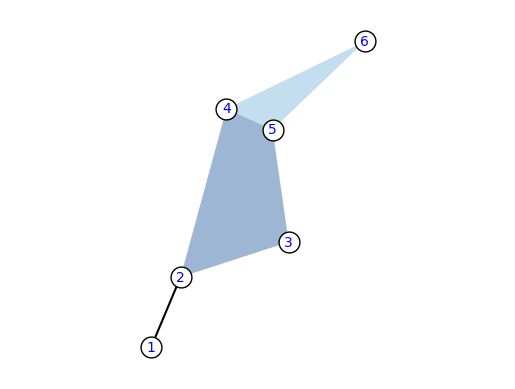

In [22]:
hyperedge_dict = {'A': [1,2], 'B': [2,3,4,5], 'C': [4,5,6]}
H = xgi.Hypergraph(hyperedge_dict)
print(f"The hypergraph has {H.nodes} nodes and {H.edges} edges")
xgi.draw(H, node_labels=True, font_color_nodes="blue")

In [23]:
Tu3 = alternative_uniformization(H, m=3, math_notation=True)
Tu3

({(0, 1, 0): 0.6666666666666666,
  (0, 0, 1): 0.6666666666666666,
  (1, 0, 0): 0.6666666666666666,
  (0, 1, 1): 0.6666666666666666,
  (1, 0, 1): 0.6666666666666666,
  (1, 1, 0): 0.6666666666666666,
  (1, 2, 3): 1,
  (1, 3, 2): 1,
  (2, 1, 3): 1,
  (2, 3, 1): 1,
  (3, 1, 2): 1,
  (3, 2, 1): 1,
  (1, 2, 4): 1,
  (1, 4, 2): 1,
  (2, 1, 4): 1,
  (2, 4, 1): 1,
  (4, 1, 2): 1,
  (4, 2, 1): 1,
  (1, 3, 4): 1,
  (1, 4, 3): 1,
  (3, 1, 4): 1,
  (3, 4, 1): 1,
  (4, 1, 3): 1,
  (4, 3, 1): 1,
  (2, 3, 4): 1,
  (2, 4, 3): 1,
  (3, 2, 4): 1,
  (3, 4, 2): 1,
  (4, 2, 3): 1,
  (4, 3, 2): 1,
  (3, 4, 5): 0.5,
  (3, 5, 4): 0.5,
  (4, 3, 5): 0.5,
  (4, 5, 3): 0.5,
  (5, 3, 4): 0.5,
  (5, 4, 3): 0.5},
 (6, 6, 6))

In [19]:
cent3 = HEC_ours(Tu3, m=3, niter=100000, tol=1e-6, verbose=True)

Finished in 9 iterations.


In [20]:
Tu4 = alternative_uniformization(H, m=4, math_notation=True)
Tu4

({(0, 1, 0, 0): 0.857142857142857,
  (0, 0, 1, 0): 0.857142857142857,
  (0, 0, 0, 1): 0.857142857142857,
  (1, 0, 0, 0): 0.857142857142857,
  (0, 1, 0, 1): 0.5714285714285714,
  (0, 1, 1, 0): 0.5714285714285714,
  (0, 0, 1, 1): 0.5714285714285714,
  (1, 0, 0, 1): 0.5714285714285714,
  (1, 0, 1, 0): 0.5714285714285714,
  (1, 1, 0, 0): 0.5714285714285714,
  (0, 1, 1, 1): 0.857142857142857,
  (1, 0, 1, 1): 0.857142857142857,
  (1, 1, 0, 1): 0.857142857142857,
  (1, 1, 1, 0): 0.857142857142857,
  (1, 2, 3, 4): 0.16666666666666666,
  (1, 2, 4, 3): 0.16666666666666666,
  (1, 3, 2, 4): 0.16666666666666666,
  (1, 3, 4, 2): 0.16666666666666666,
  (1, 4, 2, 3): 0.16666666666666666,
  (1, 4, 3, 2): 0.16666666666666666,
  (2, 1, 3, 4): 0.16666666666666666,
  (2, 1, 4, 3): 0.16666666666666666,
  (2, 3, 1, 4): 0.16666666666666666,
  (2, 3, 4, 1): 0.16666666666666666,
  (2, 4, 1, 3): 0.16666666666666666,
  (2, 4, 3, 1): 0.16666666666666666,
  (3, 1, 2, 4): 0.16666666666666666,
  (3, 1, 4, 2): 0.16666

In [15]:
cent4 = HEC_ours(Tu4, m=4, niter=100000, tol=1e-6, verbose=True)

Finished in 30 iterations.
